## **Декодирование vin кодов**

## Описание задачи

### Введение в задачу и постановка проблемы:
В современном мире автомобили играют важную роль в повседневной жизни людей. При покупке или продаже автомобиля важно иметь точное представление о его технических характеристиках и истории использования. Одним из ключевых инструментов для определения информации об автомобиле является VIN-код.

### Что такое VIN-код и почему он важен для определения информации об автомобиле:
VIN-код (Vehicle Identification Number) — это уникальный идентификационный номер, присваиваемый каждому автомобилю при производстве. Он состоит из 17 символов и содержит информацию о производителе, характеристиках автомобиля и его истории. VIN-код важен для идентификации автомобиля, проверки его истории использования, определения технических характеристик, включая модель, год выпуска, тип двигателя и многое другое.

### Цель проекта: 
разработать модель для определения информации об автомобиле по VIN-коду и предсказания его стоимости на основе обученной модели машинного обучени.
Для достижения этой цели мы будем использовать данные о VIN-кодах и соответствующих ценах автомобилей для обучения модели машинного обучения. Разработанная модель должна быть способна работать с различными типами VIN-кодов и предсказывать стоимость автомобилей с высокой точностью.


In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor, Pool
import os

**Загрузка данных**

In [2]:
# Путь к файлу
file_path = r'D:\Users\akisa\Downloads\VIN\vin_ford_train.txt'

with open(file_path, 'r', encoding='utf-8') as f:
    vin_data = f.read()

**Создание датасета**

In [3]:
# Определение различных частей VIN-кода
allowed = r'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'
wmi = f'(?P<wmi>[{allowed}]{{3}})'     # 1-3
brake = f'(?P<brake>[{allowed}])'      # 4
model = f'(?P<model>[{allowed}]{{3}})' # 5-7
engine = f'(?P<engine>[{allowed}])'    # 8
check = f'(?P<check>[{allowed}])'      # 9
year = f'(?P<year>[{allowed}])'        # 10
plant = f'(?P<plant>[{allowed}])'      # 11
num = f'(?P<num>[{allowed}]{{3}}\\d{{3}})' # 12-17

# Компиляция регулярного выражения для полного VIN-кода
vin_pattern = f'{wmi}{brake}{model}{engine}{check}{year}{plant}{num}'
vin_re = re.compile(vin_pattern)

# Поиск всех потенциальных VIN-кодов в тексте
def find_all_vins(text):
    return vin_re.findall(text)


In [4]:
# Определение регулярного выражения для проверки невалидных VIN
invalid_vin_re = re.compile(r'\b\w{17}\b')

# Функция для определения валидных и невалидных VIN-кодов
def validate_vins(vin_data):
    all_vins = invalid_vin_re.findall(vin_data)
    invalid_vins = [vin for vin in all_vins if not vin_re.match(vin)]
    return invalid_vins

# Определение регулярного выражения для обнаружения VIN-кода с ценой
price_pattern = r'(?P<price>\d+)'
vin_price_pattern = f'{vin_pattern}(?::{price_pattern})?'
vin_price_re = re.compile(vin_price_pattern)

# Функция для извлечения валидных VIN-кодов и цен
def extract_vin_prices(vin_data):
    return [x.groupdict() for x in vin_price_re.finditer(vin_data)]

In [5]:
invalid_vins = validate_vins(vin_data)
valid_vin_data = extract_vin_prices(vin_data)

# Создание DataFrame из валидных VIN-кодов и цен
df = pd.DataFrame(valid_vin_data)

print("Невалидные VIN-коды:")
for vin in invalid_vins:
    print(vin)

print("DataFrame из VIN-кодов и цен:")
print(df)

Невалидные VIN-коды:
1FM5K8D83DGB9100X
DataFrame из VIN-кодов и цен:
       wmi brake model engine check year plant     num  price
0      2FM     D   K3J      C     4    B     B  A41556  12500
1      3FA     6   P0H      7     5    E     R  208976  14500
2      3FA     H   P08      Z     1    7     R  268380   1300
3      1FM     C   U0G      X     3    D     U  C59421  15200
4      1FA     H   P2E      8     9    D     G  119368  11600
...    ...   ...   ...    ...   ...  ...   ...     ...    ...
71880  1FT     D   X17      W     1    V     N  B73890   1000
71881  1FA     D   P3F      2     3    D     L  169365  12200
71882  3FA     6   P0H      D     2    E     R  142859  16300
71883  1FA     H   P34      N     7    6     W  128169   1500
71884  1FM     C   U9D      7     8    A     K  D21749   7200

[71885 rows x 9 columns]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71885 entries, 0 to 71884
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wmi     71885 non-null  object
 1   brake   71885 non-null  object
 2   model   71885 non-null  object
 3   engine  71885 non-null  object
 4   check   71885 non-null  object
 5   year    71885 non-null  object
 6   plant   71885 non-null  object
 7   num     71885 non-null  object
 8   price   71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


| Название столбца | Описание                                       |
|------------------|------------------------------------------------|
| wmi              | Мировой индекс изготовителя                    |
| brake            | Данные о тормозной системе автомобиля          |
| model            | Модель автомобиля                              |
| engine           | Модель двигателя                               |
| check            | Контрольная цифра                              |
| year             | Год выпуска                                    |
| plant            | Код завода изготовителя                        |
| num              | Серийный номер транспортного средства          |


In [7]:
# Соединение частей VIN в одну строку
df['full_vin'] = df['wmi'] + df['brake'] + df['model'] + df['engine'] + df['check'] + df['year'] + df['plant'] + df['num']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71885 entries, 0 to 71884
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   wmi       71885 non-null  object
 1   brake     71885 non-null  object
 2   model     71885 non-null  object
 3   engine    71885 non-null  object
 4   check     71885 non-null  object
 5   year      71885 non-null  object
 6   plant     71885 non-null  object
 7   num       71885 non-null  object
 8   price     71884 non-null  object
 9   full_vin  71885 non-null  object
dtypes: object(10)
memory usage: 5.5+ MB


Посмотим есть ли невалидные VIN-коды для Северной Америки

In [9]:
# Определение регулярного выражения для проверки кода WMI
wmi_pattern = r'[1-5][ABCDEFGHJKLMNPRSTUVWXYZ1234567890][ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{2}|7[ABCDEFGHJKLMNPRSTUVWXYZ1234567890][ABCDEFGHJKLMNPRSTUVWXYZ1234567890]'

# Создание маски для строк, не соответствующих регулярному выражению
mask = ~df['full_vin'].str.contains(wmi_pattern)

# Фильтрация DataFrame по маске
filtered_df = df[mask]

# Вывод отфильтрованного DataFrame
print(filtered_df)


Empty DataFrame
Columns: [wmi, brake, model, engine, check, year, plant, num, price, full_vin]
Index: []


Посмотим есть ли невалидные VIN-коды по году

In [10]:
allowed_years = allowed.replace('U', '').replace('Z', '')

# Создание регулярного выражения для проверки года в VIN-коде
# Проверяем, что на 10-й позиции VIN-кода находится недопустимый символ года
year_pattern = f'^.{9}[^{allowed_years}].*$'

# Применение регулярного выражения к каждой ячейке DataFrame и создание маски для строк с неверным годом
mask_year = df['full_vin'].str.match(year_pattern)

# Фильтрация DataFrame по маске
filtered_df_invalid_year = df[mask_year]

# Вывод отфильтрованного DataFrame с неверным годом
print("VIN-коды с неверным годом:")
print(filtered_df_invalid_year)



VIN-коды с неверным годом:
Empty DataFrame
Columns: [wmi, brake, model, engine, check, year, plant, num, price, full_vin]
Index: []


In [11]:
# Извлечение десятого символа из каждого VIN-кода
tenth_chars = df['full_vin'].str[9]

# Получение уникальных значений из извлеченных десятых символов
unique_tenth_chars = tenth_chars.unique()

# Вывод уникальных десятых символов
print("Уникальные десятые символы в VIN-кодах:")
print(unique_tenth_chars)


Уникальные десятые символы в VIN-кодах:
['B' 'E' '7' 'D' 'C' '3' 'A' '5' '4' '9' '8' 'X' '6' 'Y' 'F' '2' 'W' 'V'
 '1' 'S' 'T' 'R' 'H' 'K' 'P']


In [12]:
unique_wmis = df['wmi'].unique()

# Вывод уникальных значений WMI
print(unique_wmis)


['2FM' '3FA' '1FM' '1FA' '1FT' '1ZV' '1FD' '2FA' '2FT' '1FB' '4F2' '4F4'
 '3FT' '4N2']


In [13]:
# URL страницы с информацией о WMI
url = "https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/Ford/VIN_Codes"

# Считываем все таблицы с указанной страницы
tables = pd.read_html(url)

# Выводим информацию о всех таблицах
for idx, table in enumerate(tables):
    print(f"Table {idx}:\n{table}\n")


Table 0:
    0                                                  1
0 NaN  Do not put specific Vehicle Identification Cod...

Table 1:
    Position Sample                         Description
0          1      2       World Manufacturer identifier
1          2      F       World Manufacturer identifier
2          3      M       World Manufacturer identifier
3          4      P                    Restraint System
4          5      K  Vehicle line, series and body code
5          6      4  Vehicle line, series and body code
6          7      J  Vehicle line, series and body code
7          8      9                         Engine code
8          9      9                         Check digit
9         10      2                          Model Year
10        11      U                      Assembly plant
11        12      C                   Sequential number
12        13      2                   Sequential number
13        14      9                   Sequential number
14        15      6        

In [14]:
# URL страницы с информацией о WMI
url = "https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/Ford/VIN_Codes"

# Считываем таблицу с указанной страницы
tables = pd.read_html(url)

# Находим таблицу с WMI
wmi_table = tables[24]  

# список уникальных WMI
unique_wmis = df['wmi'].unique()

# Фильтруем таблицу wmi_table, чтобы получить только те строки, которые содержатся в списке уникальных WMI
filtered_wmi_info = wmi_table[wmi_table['WMI'].isin(unique_wmis)]

# Вывод информации о отфильтрованных WMI
print(filtered_wmi_info)


    WMI Country                         Description  \
30  1FA     USA                  Ford Motor Company   
31  1FB     USA                  Ford Motor Company   
33  1FD     USA                  Ford Motor Company   
34  1FM     USA                  Ford Motor Company   
35  1FT     USA                  Ford Motor Company   
43  1ZV     USA          AutoAlliance International   
45  2FA  Canada  Ford Motor Company of Canada, Ltd.   
47  2FM  Canada  Ford Motor Company of Canada, Ltd.   
48  2FT  Canada  Ford Motor Company of Canada, Ltd.   
56  3FA  Mexico         Ford Motor Company (Mexico)   
61  3FT  Mexico         Ford Motor Company (Mexico)   
67  4F2     USA                  Ford Motor Company   
68  4F4     USA                  Ford Motor Company   
70  4N2     USA                  Ford Motor Company   

                         Vehicle types  
30                  Ford passenger car  
31                            Ford Bus  
33             Ford incomplete vehicle  
34        

In [15]:
df

,wmi,brake,model,engine,check,year,plant,num,price,full_vin
0,2FM,D,K3J,C,4,B,B,A41556,12500,2FMDK3JC4BBA41556
1,3FA,6,P0H,7,5,E,R,208976,14500,3FA6P0H75ER208976
2,3FA,H,P08,Z,1,7,R,268380,1300,3FAHP08Z17R268380
3,1FM,C,U0G,X,3,D,U,C59421,15200,1FMCU0GX3DUC59421
4,1FA,H,P2E,8,9,D,G,119368,11600,1FAHP2E89DG119368
...,...,...,...,...,...,...,...,...,...,...
71880,1FT,D,X17,W,1,V,N,B73890,1000,1FTDX17W1VNB73890
71881,1FA,D,P3F,2,3,D,L,169365,12200,1FADP3F23DL169365
71882,3FA,6,P0H,D,2,E,R,142859,16300,3FA6P0HD2ER142859
71883,1FA,H,P34,N,7,6,W,128169,1500,1FAHP34N76W128169


In [16]:
# Проверка наличия пропущенных значений в DataFrame df
print(df.isnull().sum())

wmi         0
brake       0
model       0
engine      0
check       0
year        0
plant       0
num         0
price       1
full_vin    0
dtype: int64


In [17]:
df = df.dropna()

In [18]:
print(df.head()) 
print(df.info())  

   wmi brake model engine check year plant     num  price           full_vin
0  2FM     D   K3J      C     4    B     B  A41556  12500  2FMDK3JC4BBA41556
1  3FA     6   P0H      7     5    E     R  208976  14500  3FA6P0H75ER208976
2  3FA     H   P08      Z     1    7     R  268380   1300  3FAHP08Z17R268380
3  1FM     C   U0G      X     3    D     U  C59421  15200  1FMCU0GX3DUC59421
4  1FA     H   P2E      8     9    D     G  119368  11600  1FAHP2E89DG119368
<class 'pandas.core.frame.DataFrame'>
Index: 71884 entries, 0 to 71884
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   wmi       71884 non-null  object
 1   brake     71884 non-null  object
 2   model     71884 non-null  object
 3   engine    71884 non-null  object
 4   check     71884 non-null  object
 5   year      71884 non-null  object
 6   plant     71884 non-null  object
 7   num       71884 non-null  object
 8   price     71884 non-null  object
 9   full_vin  7

In [31]:
df.loc[:, 'price'] = pd.to_numeric(df['price'], errors='coerce')

<Axes: >

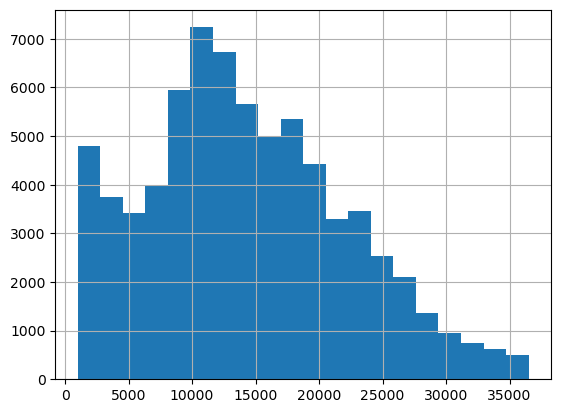

In [32]:
# Гистограмма цен
df.price.hist(bins=20)

In [33]:
# Определение категориальных признаков
categorical_features = ['wmi', 'brake', 'model', 'engine', 'check', 'year', 'plant', 'num']

In [34]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = df[categorical_features]
y = df['price']

# Разделение на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
# Создание объекта Pool, который поддерживает категориальные признаки
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

# Создание и обучение модели CatBoost
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='MAE', verbose=100)
model.fit(train_pool)

# Предсказание на тестовом наборе
y_pred = model.predict(test_pool)
mae = mean_absolute_error(y_test, y_pred)
print("MAE на тестовом наборе:", mae)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE на тестовом наборе:", rmse)

0:	learn: 5844.4296787	total: 60.9ms	remaining: 30.4s
100:	learn: 2043.9831166	total: 6.54s	remaining: 25.8s
200:	learn: 1987.8753701	total: 13.1s	remaining: 19.4s
300:	learn: 1959.1559997	total: 19.9s	remaining: 13.1s
400:	learn: 1941.0596748	total: 26.7s	remaining: 6.58s
499:	learn: 1927.3216841	total: 33.2s	remaining: 0us
MAE на тестовом наборе: 1955.960497998932
RMSE на тестовом наборе: 2807.8374810800133


In [39]:
# Создание константной модели
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train, y_train)

# Предсказание с использованием константной модели
y_pred_dummy = dummy_model.predict(X_test)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred_dummy))

print("MAE константной модели:", mae_dummy)
print("RMSE константной модели:", rmse_dummy)

MAE константной модели: 6395.046076399706
RMSE константной модели: 7854.432285549109


In [46]:
# Путь к папке, где будет сохранена модель
model_dir = r'D:\Users\akisa\Downloads\VIN'
model_filename = "catboost_model.cbm"
model_path = os.path.join(model_dir, model_filename)

model.save_model(model_path, format="cbm")

print(f"Модель сохранена по пути: {model_path}")

Модель сохранена по пути: D:\Users\akisa\Downloads\VIN\catboost_model.cbm


In [38]:
# Важность признаков
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
print("Важность признаков:")
print(feature_importance)


Важность признаков:
wmi        8.695650
brake     10.347937
model     27.530107
engine    12.580362
check      1.321075
year      32.275994
plant      7.189938
num        0.058937
dtype: float64


In [48]:
import re
import pandas as pd
from catboost import CatBoostRegressor

class CarPricePredictor:
    def __init__(self, model_path):
        # Загрузка предобученной модели
        self.model = CatBoostRegressor()
        self.model.load_model(model_path, format='cbm')
        
        # Определение формата VIN кода
        allowed = r'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'
        self.vin_pattern = re.compile(f'([{allowed}]{{3}})([{allowed}])([{allowed}]{{3}})([{allowed}])([{allowed}])([{allowed}])([{allowed}])([{allowed}]{{3}}\\d{{3}})')
        self.categorical_features = ['wmi', 'brake', 'model', 'engine', 'check', 'year', 'plant', 'num']
    
    def parse_vin(self, vin):
        match = self.vin_pattern.match(vin)
        if match:
            return match.groups()
        else:
            raise ValueError("Invalid VIN format")

    def predict_price(self, vins):
        if isinstance(vins, str):
            vins = [vins]

        data = []
        for vin in vins:
            try:
                parsed_data = self.parse_vin(vin)
                data.append(parsed_data)
            except ValueError as e:
                print(f"Error for VIN {vin}: {e}")
                continue
        
        if not data:
            return "No valid VINs provided."

        df = pd.DataFrame(data, columns=self.categorical_features)
        
        # Предсказание стоимости
        predictions = self.model.predict(df)
        df['predicted_price'] = predictions
        return df

model_path = "D:/Users/akisa/Downloads/VIN/catboost_model.cbm"
car_price_predictor = CarPricePredictor(model_path)


In [50]:
# Пример вызова для списка VIN-кодов
vin_codes = ["WBA3B9C52EP453420", "1HGCM82633A004352"]
results = car_price_predictor.predict_price(vin_codes)
print(results)

   wmi brake model engine check year plant     num  predicted_price
0  WBA     3   B9C      5     2    E     P  453420     22821.805239
1  1HG     C   M82      6     3    3     A  004352      1975.681461


## Вывод

После обучения и тестирования модели машинного обучения CatBoostRegressor для предсказания стоимости автомобилей на основе VIN-кода, мы получили следующие результаты:

- **Средняя абсолютная ошибка (MAE) на тестовом наборе:** 1955.96. Это означает, что в среднем наша модель ошибается на 1955.96 единиц стоимости при предсказании цены автомобиля.
- **Корень из среднеквадратичной ошибки (RMSE) на тестовом наборе:** 2807.84. Этот показатель говорит о том, насколько сильно в среднем отличаются прогнозы модели от реальных значений.

Для сравнения, мы также использовали константную модель:

- **MAE константной модели:** 6395.05. Это значительно выше, чем у нашей обученной модели.
- **RMSE константной модели:** 7854.43. Этот результат также значительно хуже по сравнению с моделью CatBoostRegressor.

### Итоги:
Модель CatBoostRegressor показала значительно лучшие результаты по сравнению с константной моделью, что демонстрирует эффективность применения алгоритмов машинного обучения для задачи предсказания цен на автомобили на основе VIN-кода. Эти результаты подтверждают, что модель может быть полезным инструментом для автоматической оценки стоимости автомобилей.

